In [1]:
import sympy
from sympy import *
from typing import List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time

In [2]:
from Core.EquationSolver import EquationSolver
from Core.Minimizers.DaiYuanCalculator import DaiYuanCalculator
from Core.Minimizers.FletcherReevesCalculator import FletcherReevesCalculator
from Core.Minimizers.HestenesStiefelCalculator import HestenesStiefelCalculator
from Core.Minimizers.NewtonRaphsonCalculator import NewtonRaphsonCalculator
from Core.Minimizers.PolakRibiereCalculator import PolakRibiereCalculator
from config import PRECISION, NUMBER_OF_STEPS

In [3]:
x1, x2, x3, x4 = symbols('x_1 x_2 x_3 x_4', real=True)
i = Idx('i', (1, 11))
a = Function('a')
b = Function('b')
A = [0.1957, 0.1947, 0.1735, 0.16, 0.0844, 0.0627, 0.0456, 0.0342, 0.0323, 0.0235, 0.0246];
B = [1/0.25, 1/0.50, 1/1.0, 1/2.0, 1/4.0, 1/6.0, 1/8.0, 1/10.0, 1/12.0, 1/14.0, 1/16.0]

eq = sympy.Sum(sympy.Pow(a(i) - x1 *((b(i)**2 + b(i)*x2) / (b(i)**2 + b(i)*x3 + x4)), 2),(i, 1, 11)).doit()

eq = eq.replace(a, lambda i: A[i - 1])
eq = eq.replace(b, lambda i: B[i - 1])
var = [x1, x2, x3, x4]

In [4]:
initialPosition1 = [0.3604731246866024, 0.07230024599267677, 0.11897895468122173, 0.045488678141934774]
initialPosition2 = [0.03259413754069159, 0.22363517468946045, 0.3678804141000155, 0.21481580185423677]
initialPosition3 = [0.26529854910838047, 0.1427029905292762, 0.12562171017636237, 0.3589400996677316]
initialPosition = [initialPosition1, initialPosition2, initialPosition3]

In [5]:
h = EquationSolver(HestenesStiefelCalculator(eq, var), NUMBER_OF_STEPS, "Hestenes-Stiefel")

p = EquationSolver(PolakRibiereCalculator(eq, var), NUMBER_OF_STEPS, "Polak-Ribiere")

f = EquationSolver(FletcherReevesCalculator(eq, var), NUMBER_OF_STEPS, "Fletcher-Reeves")

d = EquationSolver(DaiYuanCalculator(eq, var), NUMBER_OF_STEPS, "Dai-Yuan")

n = EquationSolver(NewtonRaphsonCalculator(eq, var), NUMBER_OF_STEPS, "Newton-Raphson")

solvings = [h,p,f,d,n]

In [6]:
solvings = [h,p,f,d,n]
for i in solvings:
    for j in initialPosition:
        i.calculate(j)
    

In [7]:
for i in solvings:
    i.display()

'Hestenes-Stiefel'

'Average time requirement: 0.2795839605331421'

'Total time requirement: 838.7518815994263'

'1. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825085968564414874993972333148072245725034919965239955195265205055427113800594151632631429, 0.1908362387826291782740477274707554737028274678840084163082658044739704555012710464735233347528697072, 0.1231172962778572770934308269691600399209023894325302804905188060698035969979699011472644085961577931, 0.1357659899815370256674290534658879819840722845093693444728525675002695536142587932276899340284483388]'

'Calculated evaluation :0.0003074859878056064443334115311263281153629365677085767099047185819108293200222147183380646055409611192'

'2. Calculation'

'Step count: 1001'

'Calculated X :[0.192833452982508604661781358439005270540461781517823131079782735714653635289206938066463395968018518, 0.1908362387826289791201958824120290199101807879807601751303841790061082609187681680387767338587920705, 0.1231172962778572246522533151574244257915006901703524136860475886309420778447214489765624358329333937, 0.1357659899815369368147977491348042623997699679032445712671313592494637841199354510414143407409862857]'

'Calculated evaluation :0.0003074859878056064443334115311262530114729099482766695974492780690854765372606633073579471014774897369'

'3. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048617574029999074923880822108761124772178660454938956846507914514155228965960773119, 0.1908362387826289762323290450722307071203563910729623253428677764380643287483664028350632373278881324, 0.123117296277857224766501059641279122714728794696861553928016468884826743909398063396919393865396779, 0.1357659899815369353970987274083894686432388411281145193077948729070383131326501369668689111721849107]'

'Calculated evaluation :0.0003074859878056064443334115311262529901433823509950099706147918083494443767013967000129180130472186289'

'-----'

'Polak-Ribiere'

'Average time requirement: 0.25197738393147784'

'Total time requirement: 755.9321517944336'

'1. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606262430594907841619843353183597923377339628296021942716637975236681754445148945, 0.1908362387826289762450121736614484240952624061737420218390375551068133402257090092277343436824951537, 0.1231172962778572247597425173342403856666678119305081186222660386299333374427750833246873393618727479, 0.1357659899815369354049923902414777195627288548257554811136588781941310778382550275469604913944007759]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417710708568328578745146332484253731586526534126533008662007146'

'2. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606193287427022512234558097639556284636486199594841969104251199893927537084628212, 0.1908362387826289762452060292745309108989917350444310551352078515615945280998945919344000407720618471, 0.1231172962778572247597966952213138982608371700162557716332188555657688498111725396430644476668375855, 0.1357659899815369354050789650244127726317798202473807318590445245245343450695032917926749424886787749]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417709760654360007738418132177904875891663028037374258810758280'

'3. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606174917667809901608605767023884606055307397494579141808149975977399934804152178, 0.1908362387826289762452571473448141582359585593996885517389182797318933706648486396279762566444851238, 0.1231172962778572247598131869570568696509857420842832197111725721388736839758791086224900221441527396, 0.1357659899815369354051011794282883115677078050185346518399119167749994922957045500387897910391982546]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417709744042254154100944730557870468734907826272002849555425963'

'-----'

'Fletcher-Reeves'

'Average time requirement: 0.178679763396581'

'Total time requirement: 536.039290189743'

'1. Calculation'

'Step count: 1001'

'Calculated X :[0.1928332259178784408738145044216648123892890815256892303979855033722243737640601294662236735522152209, 0.19083940876955108861837520127584781639256387468241475658468924962479830370135355991938352596997134, 0.12311663280209364882549878440713255288676697132888148519057119330586486150986622701087207537790346, 0.1357676502704801802753475341738006102866815055975168978727144466000924024940609997423890207077071453]'

'Calculated evaluation :0.0003074859878457649451743235334899871698040211301905913813122605803153144736708495523294162043845869195'

'2. Calculation'

'Step count: 1001'

'Calculated X :[0.192832587222281890164772613143120972650176435283795826035285803872781393056160130131719666938145999, 0.1908832178781671294755316493752021558311394593655387365616701179906806108484147063335540363589262348, 0.1231302429608190455030861102781026781475268060555151517555938101394762071879618397842117782618473138, 0.1357881798123937016167455269158010105380016647584678781810318737867055562467747144005148938375352936]'

'Calculated evaluation :0.0003074859942461591941810414570408323597611425465965930133468462998297571925415079730663726362291852975'

'3. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334020077883976570589263693036354266871621208518816981195401235125477981108490335630661522739226, 0.1908369645695659861348685477782661068140154467346936916496373725183438552987195108224655756968002613, 0.1231172588672747973948006445024921093674057745466400389476234061697790830232680599391506561367126009, 0.1357663380008983249772167048935896417772075449306341995967734143737246603776443785094150514718272409]'

'Calculated evaluation :0.0003074859878069568158983614161976275224469131402825352952635946724168549115301093157342489406623258036'

'-----'

'Dai-Yuan'

'Average time requirement: 0.1365993162790934'

'Total time requirement: 409.7979488372803'

'1. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606178591793801262303308859353710296289202654841415200888944923680793111920924087, 0.1908362387826289762452407206805237148967321988257167919967769419370272490584071870952972097670022204, 0.1231172962778572247598060591326890377447275378299433760075368515751359951110561616341857148060852031, 0.1357659899815369354050942129946270925228656205609806931230018831453896192526849869055518573959387262]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417709738142329469507270016168430833085926419789744010558145784'

'2. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606309913715941636140385922608375931059029816898371631470727048954206183392067705, 0.1908362387826289762452102781813526691398361419034791213423418847887960256028925813986772033172816115, 0.1231172962778572247599146656891715395923796420772414350907128460648760390209125388238065558689803801, 0.1357659899815369354050677312050745174802667192806972593974847646514935171727237801893985999364309976]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417710962073773131918885459167464044168280508500920431010852046'

'3. Calculation'

'Step count: 1001'

'Calculated X :[0.1928334529825086048606178591793020090948995375166491076162131307074469359944166443431759333065923941, 0.1908362387826289762452407206853216468515866998502741334791198478355177140038826555526201567459524518, 0.1231172962778572247598060591353251660144323147802321393985002324764821718865929314414975065133604738, 0.135765989981536935405094212996596973062439912538241630958700145630575544655996949399219534958987881]'

'Calculated evaluation :0.0003074859878056064443334115311262529901417709738142329469506637019395176571840781529425103965480714626'

'-----'

'Newton-Raphson'

'Average time requirement: 0.17660719899935873'

'Total time requirement: 189.67613172531128'

'1. Calculation'

'Step count: 52'

'Calculated X :[0, -0.08365384591149596495509317439000759701474590463354036483589293844343486292917954156193950931039133248, -0.1907831635529866278499198374096360599426989463418389891857537593219482474151306167529385789939172328, 0.008955096426671871893276153800183855823191937307686870740314085348813251969553333084623191273981893896]'

'Calculated evaluation :0.1484131800000000080200712737621420961603571965293923194034889980182888573768257289842154023062903434'

'2. Calculation'

'Step count: 1001'

'Calculated X :[-47.04748882202231589187584721829866574984642436015222348733906274588363377311880495024890726017137248, 8540020489154738422.05963563776392958558204344757019474901146511507714328713840218800149792645203623, -1729069461478711040855.382977817258724262133709042694156367480520194709094783933885493962684465420158, -703767464560016069008.6247762953842324865170474311167084045348570575727423919112724729028983408953124]'

'Calculated evaluation :0.001794062750975618375753407955556329674690183377733100273827596494678353822306788143541000691453388166'

'3. Calculation'

'Step count: 24'

'Calculated X :[1.440868768464276084845252960832066096877262161762205356282226935979923421235241114670245435956984843e-156, 81.69585628257691385573923442621632053705429954286316833102372944072681026885143240030339442382370663, 863.5377778270355203659522669341169726238176648461423696834914871471129767894363491621272483028706202, -1086.762432488250413818413600851092058577789105447670914115785365364365584896175743601020566731929394]'

'Calculated evaluation :0.1484131800000000080200712737621420961603571965293923194034889980182888573768257289842154023062903434'

'-----'

In [8]:
for error in [0.01, 0.001, 0.0004, 0.00031, 0.000308]:
    display("")
    display("Absolute Error: " + str(error))
    for solve in solvings:
        i = solve.getStep(error)
        if i is not None:
            display(solve.name)
            display("Step: " + "/".join(i))
        else:
            display(solve.name)
            display("Not reach below " + str(error))

''

'Absolute Error: 0.01'

'Hestenes-Stiefel'

'Step: 3/1/1'

'Polak-Ribiere'

'Step: 3/1/1'

'Fletcher-Reeves'

'Step: 2/1/1'

'Dai-Yuan'

'Step: 2/1/1'

'Newton-Raphson'

'Step: -/16/-'

''

'Absolute Error: 0.001'

'Hestenes-Stiefel'

'Step: 7/8/5'

'Polak-Ribiere'

'Step: 4/5/5'

'Fletcher-Reeves'

'Step: 5/4/4'

'Dai-Yuan'

'Step: 4/4/4'

'Newton-Raphson'

'Step: -/22/-'

''

'Absolute Error: 0.0004'

'Hestenes-Stiefel'

'Step: 9/38/8'

'Polak-Ribiere'

'Step: 6/18/5'

'Fletcher-Reeves'

'Step: 7/11/5'

'Dai-Yuan'

'Step: 5/11/7'

'Newton-Raphson'

'Step: -/-/-'

''

'Absolute Error: 0.00031'

'Hestenes-Stiefel'

'Step: 20/63/110'

'Polak-Ribiere'

'Step: 18/99/76'

'Fletcher-Reeves'

'Step: 82/62/44'

'Dai-Yuan'

'Step: 22/35/29'

'Newton-Raphson'

'Step: -/-/-'

''

'Absolute Error: 0.000308'

'Hestenes-Stiefel'

'Step: 62/65/123'

'Polak-Ribiere'

'Step: 38/116/120'

'Fletcher-Reeves'

'Step: 165/91/90'

'Dai-Yuan'

'Step: 31/52/30'

'Newton-Raphson'

'Step: -/-/-'

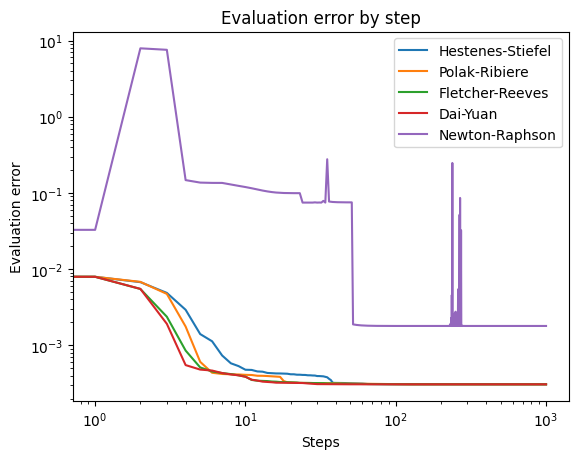

In [9]:
ay = plt.gca()
ay.set_yscale('log')
ay.set_xscale('log', base = 10)

plt.xlabel("Steps")
plt.ylabel("Evaluation error")
plt.title("Evaluation error by step")
for i in solvings:
    plotVar = i.evaluationPlot()
    xpoints = np.array(plotVar[0])
    ypoints = np.array(plotVar[1])
    plt.plot(xpoints, ypoints, label=i.name)

plt.legend()
plt.show()

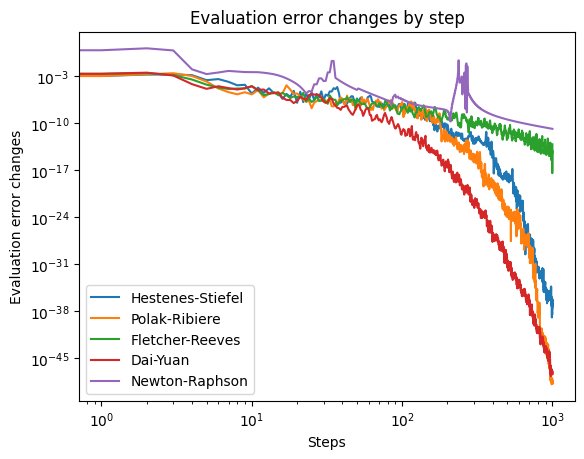

In [10]:
ay = plt.gca()
ay.set_yscale('log')
ay.set_xscale('log', base = 10)

plt.xlabel("Steps")
plt.ylabel("Evaluation error changes")
plt.title("Evaluation error changes by step")

for i in solvings:
    plotVar = i.deltaEvaluationPlot()
    xpoints = np.array(plotVar[0])
    ypoints = np.array(plotVar[1])
    plt.plot(xpoints, ypoints, markevery = [len(j) - 1 for j in i.evaluation], label=i.name)

plt.legend()
plt.show()

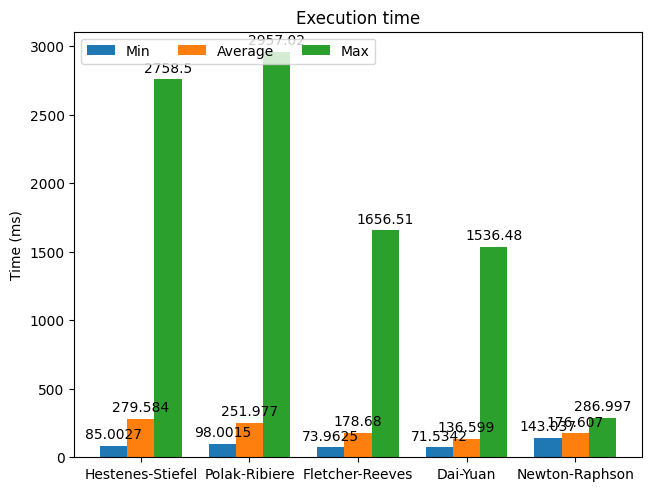

In [11]:
species = tuple(i.name for i in solvings)
penguin_means = {
    'Min': tuple(i.minTime() * 1000 for i in solvings),
    "Average": tuple(i.averageTime() * 1000 for i in solvings),
    'Max': tuple(i.maxTime() * 1000 for i in solvings),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (ms)')
ax.set_title('Execution time')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)

plt.show()

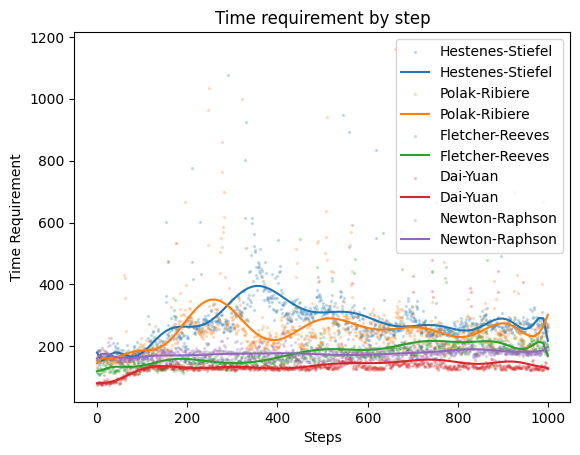

In [16]:
ay = plt.gca()

plt.xlabel("Steps")
plt.ylabel("Time Requirement")
plt.title("Time requirement by step")
for i in solvings:
    plotVar = i.timePlot()
    xpoints = np.array(plotVar[0])
    ypoints = np.array([j*1000 for j in plotVar[1]])
    mymodel = np.poly1d(np.polyfit(xpoints, ypoints, int(15)))
    myline = np.linspace(0, NUMBER_OF_STEPS-1, 100)
    plt.scatter(xpoints, ypoints, label = i.name, s = 2, alpha = 0.2)
    plt.plot(myline,mymodel(myline), label = i.name)

plt.legend()
plt.show()

In [26]:
dictionary = list({i.name: sum(j[-1] for j in i.evaluation)/3 for i in solvings}.items())
def sortDict(dict):
  return dict[1]
dictionary.sort(key = sortDict)
dictionary

[('Polak-Ribiere',
  0.0003074859878056064443334115311262529901417710071088314246861503065073343025404365796145303372342730463),
 ('Dai-Yuan',
  0.0003074859878056064443334115311262529901417710146119477356977597498243690483031662819238589469016570819),
 ('Hestenes-Stiefel',
  0.0003074859878056064443334115311262780389930762889934187593229294864485834113280915752363099066885564950),
 ('Fletcher-Reeves',
  0.0003074859899662936517512421355761490173373589390232398966409005175206421925808222803766792604253660069),
 ('Newton-Raphson',
  0.09954014091699187813863198515994684066513485881217257969360186417708535619198608203732393510134469166)]